In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gggenes)
library(ggtree)
library(Biostrings)
library(msa)
library(ape)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


ggtree v3.14.0 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96


Attaching package: ‘ggtree’


The following object is masked from ‘package:tidyr’:

    expand


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep,

In [3]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [4]:
## Output files
out_path <- 'analysis/'
dir.create(out_path)

Warning message in dir.create(out_path):
“'analysis' already exists”


In [16]:
# Define colors
cols <- list()

cols$modification <- c(
    'None' = 'black',
    'Unknown' = 'grey',
    'glucose' = 'seagreen',
    #'arabinose' = 'yellow',
    '5ara-hdC' = 'darkorange',
    '5ara-ara-hdC' = 'indianred',
    '5ara-ara-ara-hdC' = 'purple',
    '>2 Aat genes' = 'pink'
)

cols$group <- c(
    'None'='black','Generic'='cyan3','Thy syn only'='white','Glucosylation'='seagreen','Arabinosylation'='orange'
)

cols$annotation <- c(
    'DNA polymerase' = 'grey50',
    #'DNA clamp' = 'grey60',
    'dCTPase' = 'purple',
    'peptidase U32' = 'cyan2',
    'dCMP hydroxylase' = 'cyan3',
    'dCMP hydroxymethylase' = 'cyan4',
    'dNMP kinase' = 'dodgerblue',
    #'Thy syn' = 'navy', # aquamarine
    'putative glycosyltransferase' = 'seagreen',
    'alpha-glucosyl-transferase' = 'seagreen1',
    'beta-glucosyl-transferase' = 'seagreen3',
    'arabinose isomerase' = 'darkorange',
    'phosphoheptose isomerase' = 'orange',
    'NTP transferase' = 'yellow',
    'thymidylate kinase' = 'hotpink',
    'aat' = 'firebrick',
    'aat 1' = 'indianred',
    'aat 2' = 'red',
    'Other' = 'grey90'
)

In [23]:
# Read data
data <- readRDS('analysis/training_features.Rds')

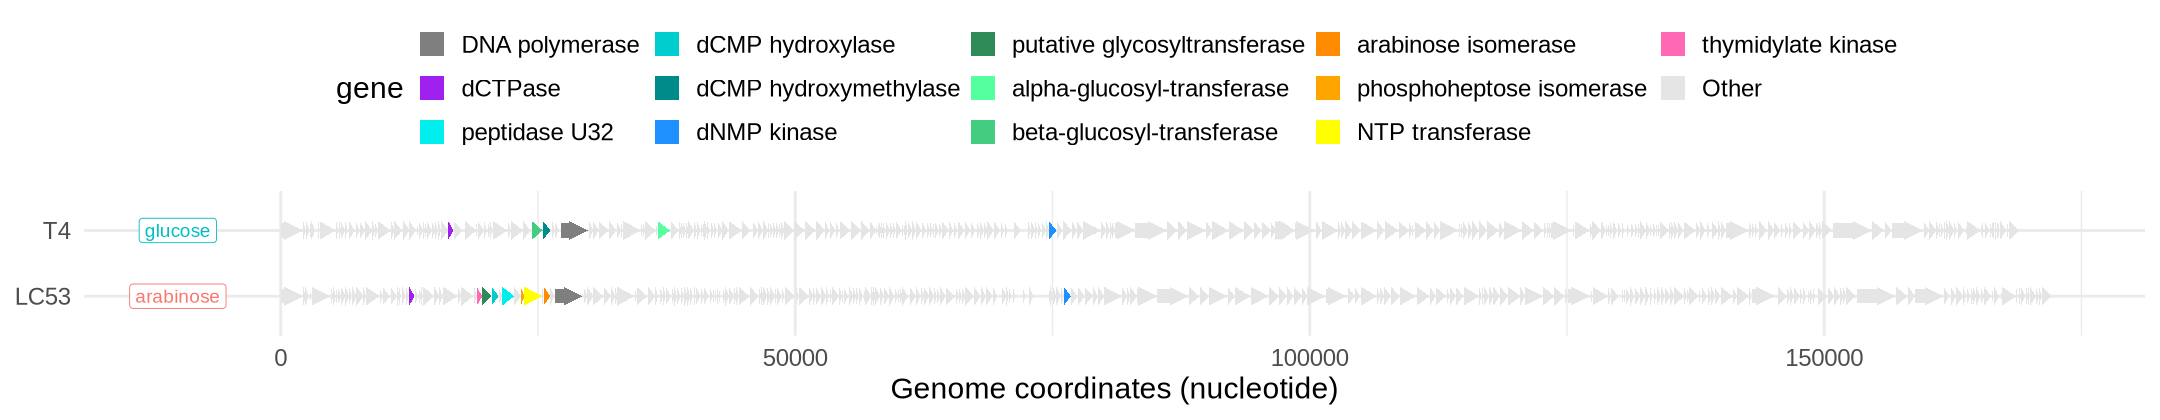

In [26]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=3.5)

## Fetch data
df <- data %>% subset(Name %in% c('Escherichia phage T4','Serratia phage vB_SspM_LC53'))

## Change name
df$short_name <- NA
df$short_name[df$Name == 'Escherichia phage T4'] <- 'T4'
df$short_name[df$Name == 'Serratia phage vB_SspM_LC53'] <- 'LC53'

## Create annotations
ann <- df %>% select(Accession, modification, aat, short_name) %>% unique()
ann$modification[[2]] <- 'arabinose'

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Accession <- factor(df$Accession, unique(df$Accession))

## Plot
p1 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=3), 
           col = guide_none()) +
    labs(x = "Genome coordinates (nucleotide)", y = NULL, fill='gene')
p1

Warning message:
“Removed 461 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 543 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_label()`).”


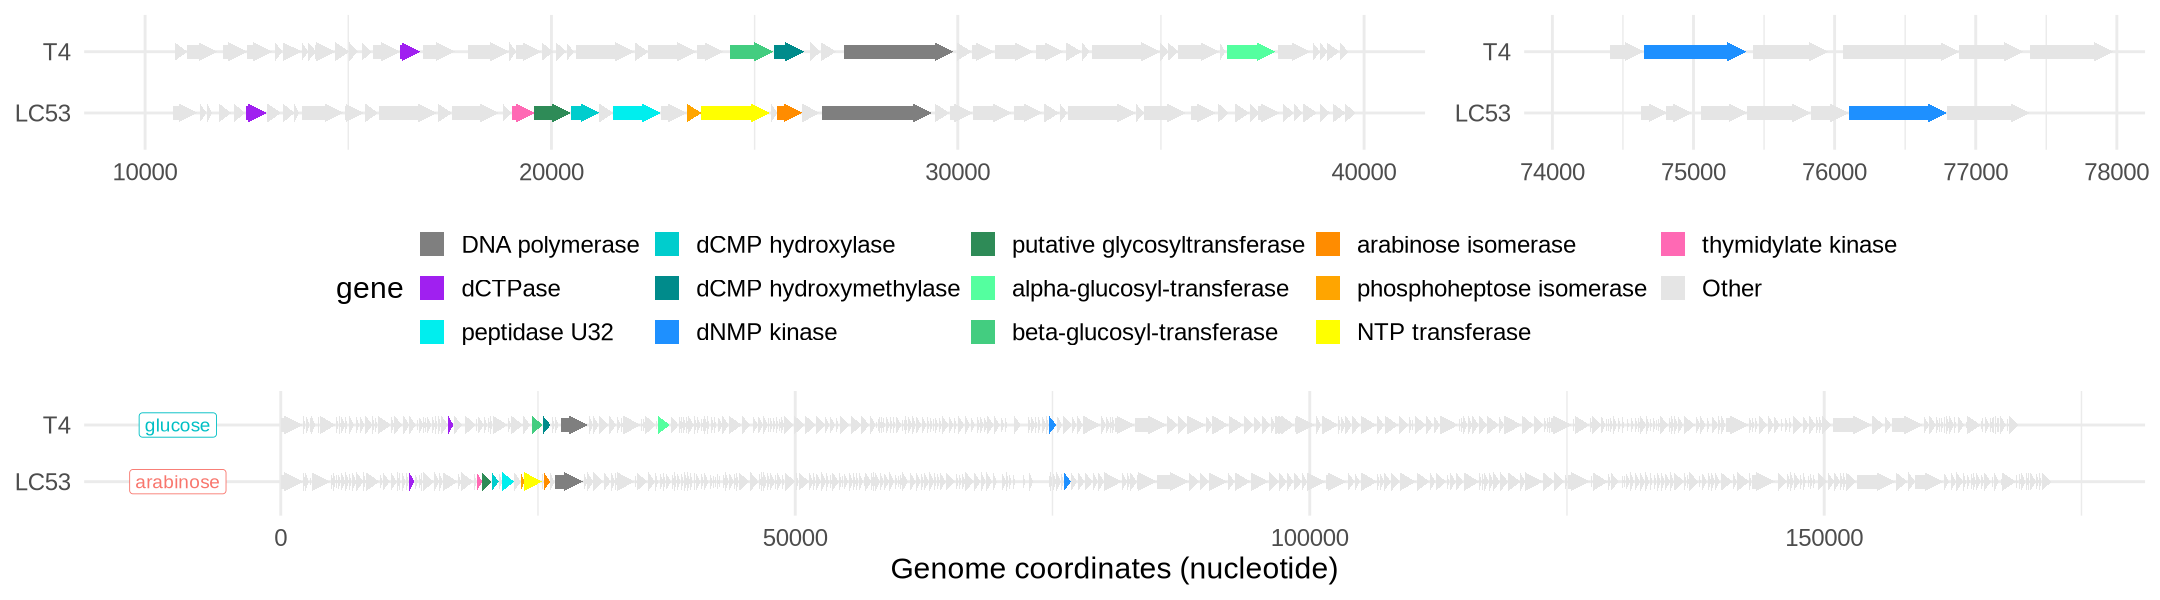

In [29]:
# Focus on genomic regions
options(repr.plot.width=18, repr.plot.height=5)

## Plot
p2 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_x_continuous(limits = c(10000, 40000)) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_none(), 
           col = guide_none()) +
    labs(x = NULL, y = NULL)

## Plot
p3 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_x_continuous(limits = c(74000, 78000)) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_none(), 
           col = guide_none()) +
    labs(x = NULL, y = NULL)

## Plot
p4 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_x_continuous(limits = c(142000, 148000)) +
    geom_label(data=ann, aes(x=-10000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_none(), 
           col = guide_none()) +
    labs(x = NULL, y = NULL)

## Layout
grid <- cowplot::plot_grid(p2,p3, nrow = 1, rel_widths = c(2,1))
grid <- cowplot::plot_grid(grid, p1, nrow=2, rel_heights = c(1,2))
grid

## Save
fn <- paste0(out_path,'figure_1E','.png')
ggsave(fn, grid, width = 18, height = 4.5, device = 'png')

fn <- paste0(out_path,'figure_1E','.pdf')
ggsave(fn, grid, width = 18, height = 4.5)

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 104 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


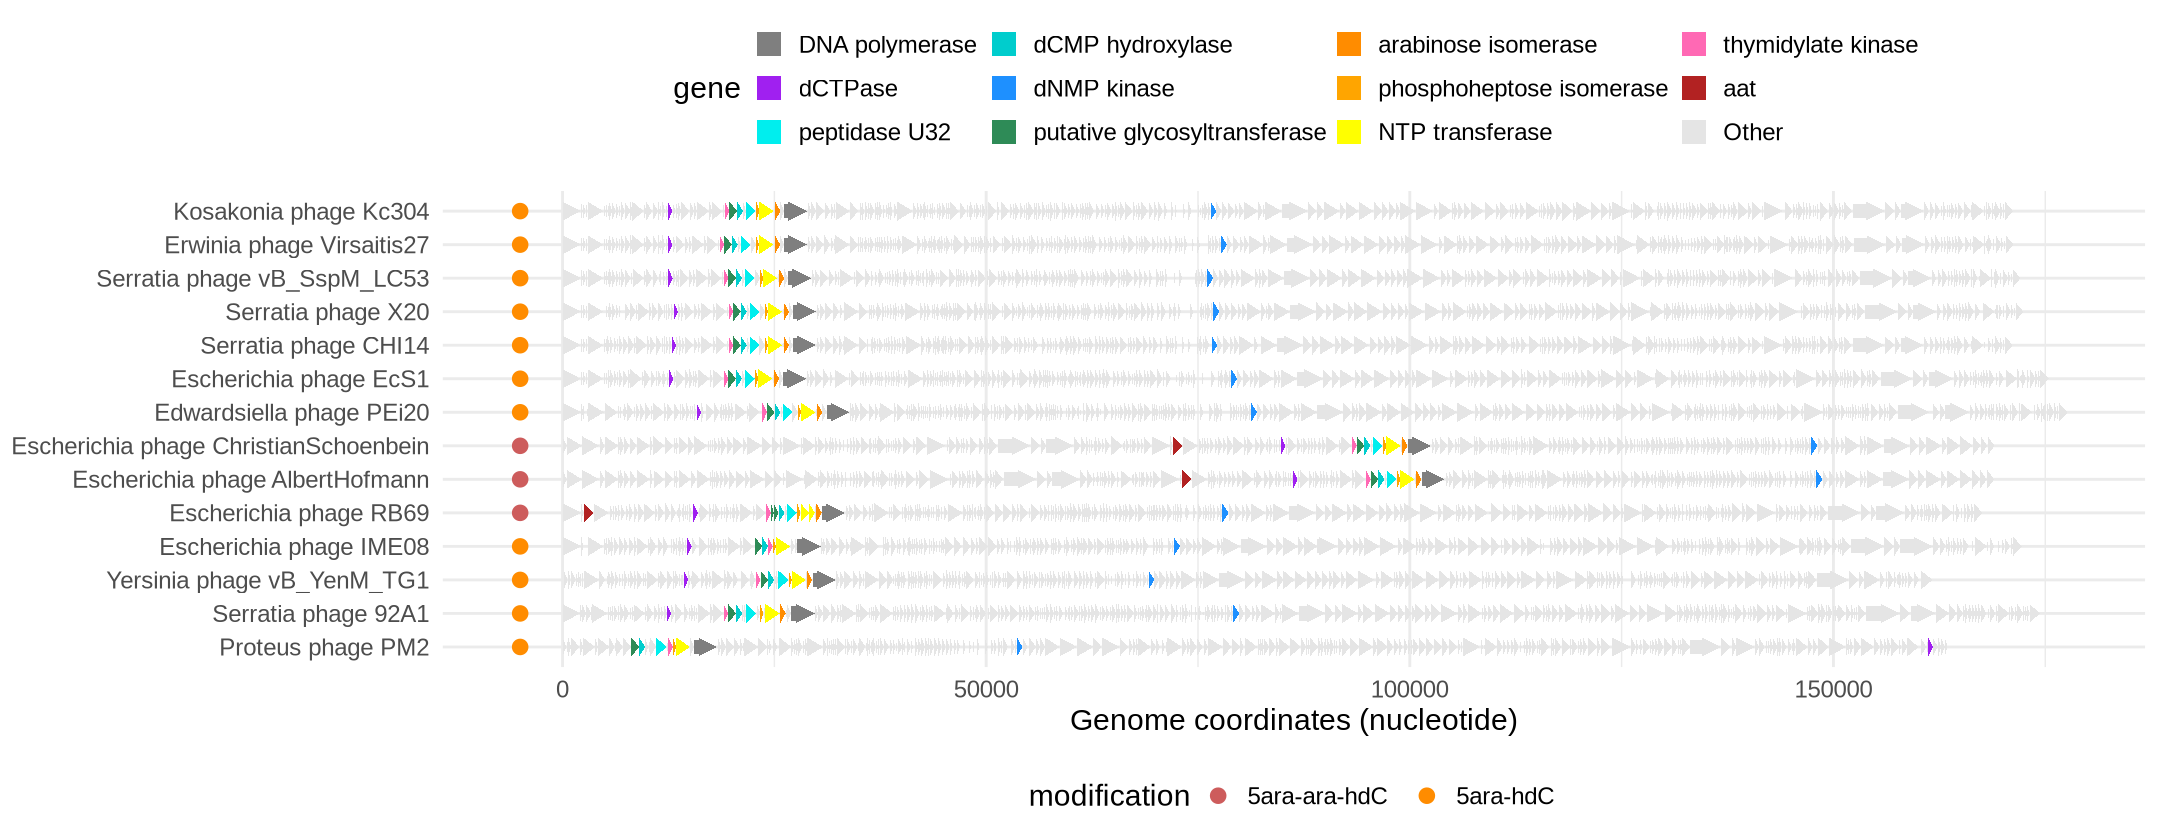

In [30]:
# Visualize genomes with different arabinosylation states
options(repr.plot.width=18, repr.plot.height=7)

## Fetch data
index <- unique(data$Name)[c(11,32,33,29,24,27,21,13,12,14,15,22,35,28)]
df <- data %>% subset(Name %in% index)

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, rev(index))

## Plot
p1 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=3), 
           col = guide_legend(position = 'bottom', nrow=1)) +
    labs(x = "Genome coordinates (nucleotide)", y = NULL, fill='gene')
p1

Warning message:
“Removed 25 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


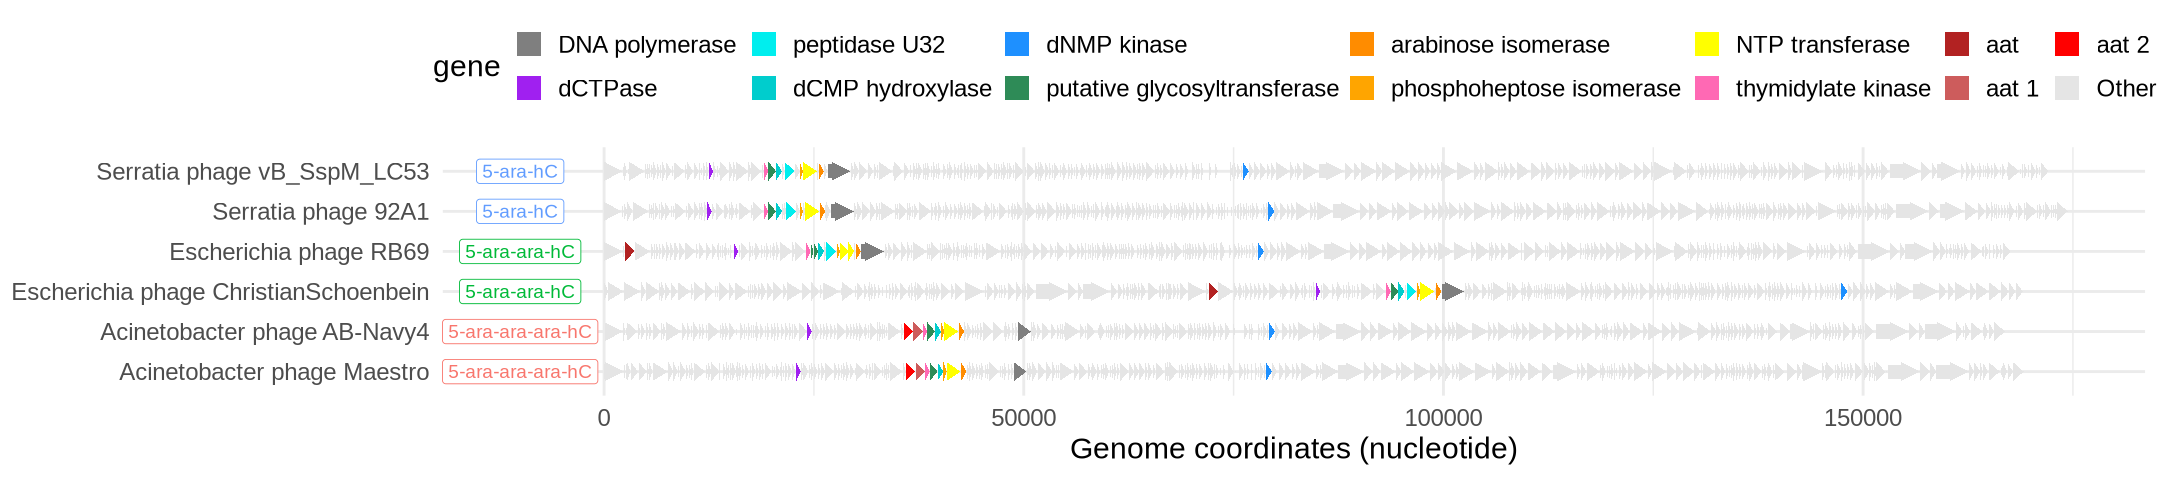

In [31]:
# Visualize genomes with different arabinosylation states
options(repr.plot.width=18, repr.plot.height=4)

## Fetch data
index <- unique(data$Name)[c(33,35,14,13,31,9)]
df <- data %>% subset(Name %in% index)

## Update modification
df$modification[df$Name %in% c('Serratia phage vB_SspM_LC53','Serratia phage 92A1')] <- '5-ara-hC'
df$modification[df$Name %in% c('Escherichia phage RB69','Escherichia phage ChristianSchoenbein')] <- '5-ara-ara-hC'
df$modification[df$Name %in% c('Acinetobacter phage AB-Navy4','Acinetobacter phage Maestro')] <- '5-ara-ara-ara-hC'
## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Name <- factor(df$Name, rev(index))

## Plot
p1 <- ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    geom_label(data=ann, aes(x=-10000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_none()) +
    labs(x = "Genome coordinates (nucleotide)", y = NULL, fill='gene')
p1

In [ ]:
# Backup / Graveyard

In [ ]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=5)

heatmap_genes <- c('DNA pol','DNA clamp','NTP transfer','Thy syn','dCTPase','Hydroxylase','Pep U32','dNMP kinase','Glu transfer',
                   'Ara iso','pHep iso','Thy kin','Aat')
heatmap_genes <- levels(data$annotation)
heatmap_genes <- heatmap_genes[heatmap_genes != 'Other']

## Summarize gene counts
df <- data %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- df$annotation %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()

### Row
rann <- data.frame(
    row.names = rownames(mat),
    group = c('Generic','Generic','Generic','Generic','Generic','Generic','Generic','Generic','Glucosylation',
              'Arabinosylation','Arabinosylation','Arabinosylation','Arabinosylation')
)
rann$group <- factor(rann$group, names(cols$group))

### Col
cann <- data.frame(
    row.names = colnames(mat)
)

##  Cluster

### Level 1
cann$group <- 'Thy syn only'
cann$group[mat['Hydroxylase',] > 0 | mat['dCTPase',] > 0 | mat['dNMP kinase',] > 0] <- 'Generic'
cann$group[cann$group == 'Generic' & mat['Glu transfer',] > 0] <- 'Glucosylation'
cann$group[cann$group == 'Generic' & mat['Ara iso',] > 0 | mat['Thy kin',] > 0] <- 'Arabinosylation'
cann$group <- factor(cann$group, names(cols$group))

### Level 2
cann$modification <- 'none'
cann$modification[cann$group == 'Glucosylation'] <- 'glucose'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==0] <- '5ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==1] <- '5ara-ara-hdC'
cann$modification[cann$group == 'Arabinosylation' & mat['Aat',]==2] <- '5ara-ara-ara-hdC'

## Order
mat <- mat[,order(cann$group, cann$modification, decreasing = c(FALSE, TRUE), method = 'radix')]

## Plot
p1 <- pheatmap(mat, 
               cluster_rows = FALSE, cluster_cols=FALSE,
               show_colnames=FALSE, annotation_colors=cols,
               annotation_col = cann,
               fontsize = 15,
               gaps_col             = head(as.numeric(cumsum(table(cann$group)[table(cann$group) > 0])), -1),
               gaps_row             = head(as.numeric(cumsum(table(rann$group)[table(rann$group) > 0])), -1)
              )

## Quantify
table(cann$group)
table(cann$modification)
levels(data$annotation)

In [ ]:
# Auto-annotate clusters

## Summarize
df <- rann %>% group_by(cluster) %>% summarize(annotation=paste(unique(annotation), collapse=','))

## Transfer unique annotations
df$label <- NA
index <- which(df$annotation %in% data$annotation)
df$label[index] <- as.character(df$annotation[index])

## Manually assign cluster identity
index <- which(is.na(df$label))
df$label[index] <- df$cluster[index]

## Split groups with same label
df$label <- make.unique(df$label, sep = '_')

## View
df

## Transfer label to rann
index <- match(rann$cluster, df$cluster)
rann$label <- df$label[index]

## Transfer label to data
index <- match(data$acc_protein_key, rownames(rann))
data$label <- rann$label[index]

In [ ]:
## Vote
lookup <- character(length = ncol(result))
for (n in 1:ncol(result)) {
    v <- result[,n]
    names(v) <- rownames(result)
    n_min <- min(v)
    lookup[[n]] <- names(which(v == min(v)))
}
index <- match(colnames(result), data$Gene.CDS.Protein.FASTA.Sequence.ID)
data$annotation[index] <- lookup

In [ ]:
# Check phages with annotated proteins
sel <- tables$proteins
sel$genome_accession <- NA
for (n in 1:nrow(sel)) {
    # Select ID
    i <- sel$protein_accession[[n]]

    # Error handling
    if (is.na(i)) {next}

    # Run ENTREZ query
    report <- try(entrez_fetch(db="protein", id=i, rettype = 'jsonl'))

    # Skip unknown sequences
    if (class(report) == 'try-error') {next}
    
    # Get NCBI protein report
    report <- str_split(report, '\n')[[1]] # Split into lines
    index <- which(str_detect(report, 'DBSOURCE')) # Detect which line (usually 5)
    db_source <- report[[index]]
    db_source <- str_split(db_source, '\\ ')[[1]]
    db_source <- db_source[[length(db_source)]] # Select last element
    sel$genome_accession[[n]] <- db_source
}

In [15]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pheatmap_1.0.12     ape_5.8-1           msa_1.38.0         
 [4] Biostrings_2.74.0   GenomeInfoDb_1.42.0 XVector_0.46.0     
 [7] IRanges_2.40.0      S4Vectors_0.44.0    BiocGenerics_0.52.0
[10] ggtree_3.14.0       gggenes_0.5.1       cowplot_1.1.3      
